# ***5. Estimating Counts***

> ## **5.1 The Train Problem**
***

> _A railroad numbers its locomotives in order 1…N. One day you see a locomotive with the number 60. Estimate how many locomotives the railroad has._

We know the railroad has 60 or more locomotives. But how many more? We need to break this question into two steps:

- What did we know about $N$ before we saw the data?

- For any given value of $N$ what is the likelihood of seeing the data (a locomotive with number 60)?

The answer to the first question is the prior. The answer to the second is the likelihood.

Most likely estimation of locomotives:  60
Mean of the posterior:  333.41989326370776


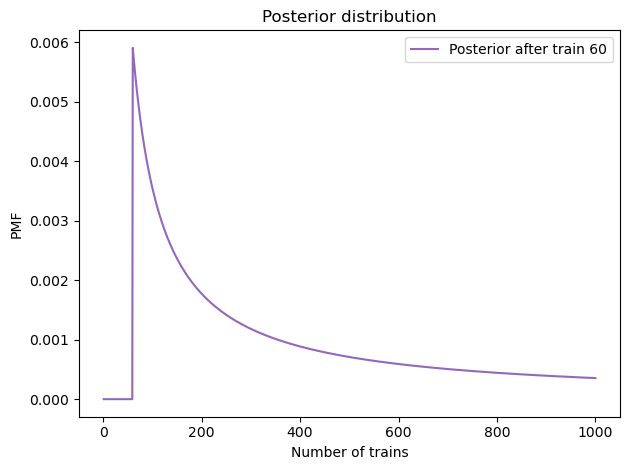

In [28]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

import numpy as np
from empiricaldist import Pmf
from utils import decorate

# Define the prior.
hypos = np.arange(1, 1001)
prior = Pmf(1, hypos)

# Likelihood of the data. 
# In a hypothetical fleet of N locomotives, what is the probability that we would see number 60? 
# If we assume that we are equally likely to see any locomotive, the chance of seeing any particular one is 1/N

def update_train(pmf, data):
    """Update pmf based on new data."""
    hypos = pmf.qs
    likelihood = 1 / hypos
    impossible = (data > hypos)
    likelihood[impossible] = 0
    pmf *= likelihood
    pmf.normalize()
    
# Update
data = 60
posterior = prior.copy()
update_train(posterior, data)

# Most likely value of locomotives 
print("Most likely estimation of locomotives: ", posterior.max_prob()) # Maximize the chance of getting the estimate correctly

# Expected value
print ("Mean of the posterior: ", posterior.mean()) # Minimize the chance of error

# Plot
posterior.plot(label='Posterior after train 60', color='C4') 
decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Posterior distribution')

If you played this guessing game over and over, using the mean of the posterior as your estimate would minimize the mean squared error over the long run.

> ## **5.2 Sensitivity to the Prior**
***

The posterior is highly sensitive to an uninformed prior. The table below shows what happens as we vary the upper bound of the previous problem: 

In [29]:
import pandas as pd

df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    update_train(pmf, data=60)
    df.loc[high] = pmf.mean()
    
df

,Posterior mean
Upper bound,
500,207.079228
1000,333.419893
2000,552.179017


When the posterior is sensitive to the prior, there are two ways to proceed:

- Get more data.

- Get more background information and choose a better prior.

With more data, posterior distributions based on different priors tend to converge. For example, suppose that in addition to train 60 we also see trains 30 and 90. Here’s how the posterior means depend on the upper bound of the prior, when we observe three trains:

In [30]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    for data in dataset:
        update_train(pmf, data)
    df.loc[high] = pmf.mean()
    
df

,Posterior mean
Upper bound,
500,151.849588
1000,164.305586
2000,171.338181


> ## **5.3 Power Law Prior**
***

If more data are not available, another option is to improve the priors by gathering more background information. This law suggests that if there are 1000 companies with fewer than 10 locomotives, there might be 100 companies with 100 locomotives, 10 companies with 1000, and possibly one company with 10,000 locomotives.

Mathematically, a power law means that the number of companies with a size $N$, is proportional to $N^{\alpha}$, where $\alpha$ is a parameter that is often near 1 and thus it simplifies to $(\frac{1}{N})$, This means that larger values of $N$ are less likely in a way that follows a power-law decay.

We can construct a power law prior like this:

Normalizing constant:  8.178368103610282


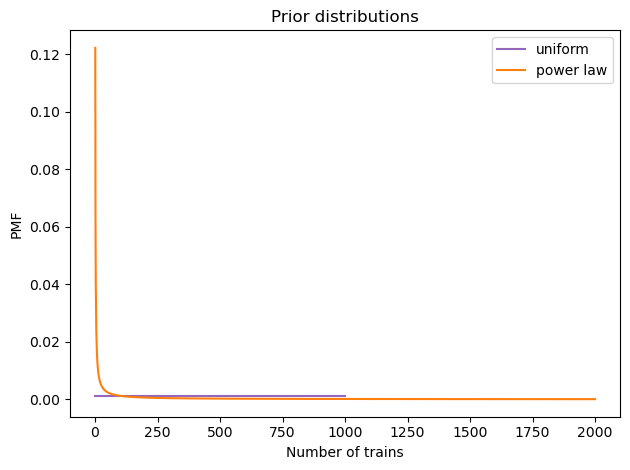

In [31]:
# Power law prior
alpha = 1.0
ps = hypos**(-alpha)
power = Pmf(ps, hypos, name='power law')
print("Normalizing constant: ", power.normalize())

# Uniform (uninformed) prior
hypos = np.arange(1, 1001)
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

# Plot
uniform.plot(color='C4')
power.plot(color='C1')
decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Prior distributions')

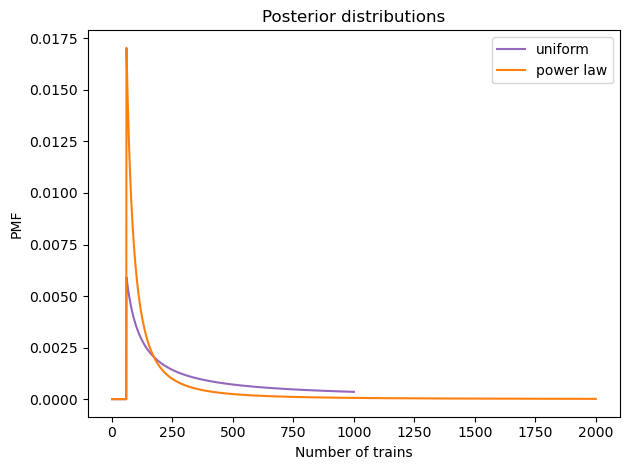

In [32]:
# Update
dataset = [60]
update_train(uniform, dataset)
update_train(power, dataset)

# Updated plot
uniform.plot(color='C4')
power.plot(color='C1')
decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Posterior distributions')

<div class="alert alert-block alert-info">
<b>Note:</b> The power law gives less prior probability to high values, which yields lower posterior means, and less sensitivity to the upper bound.
</div>

Here’s how the posterior means depend on the upper bound when we use a power law prior and observe three trains:

In [33]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound' # N = Maximum possible number of locomotives a company could have

alpha = 1.0
dataset = [30, 60, 90] # Observations

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1) # Set of possible values for N
    ps = hypos**(-alpha) # Model the assumption that smaller fleet sizes are more common than larger ones.
    power = Pmf(ps, hypos) # Update the probability distribution given observed locomotive numbers 
    for data in dataset:
        update_train(power, data)
    df.loc[high] = power.mean()
    
df

,Posterior mean
Upper bound,
500,130.708470
1000,133.275231
2000,133.997463


Now the differences are much smaller and even with an arbitrarily large upper bound, the mean converges on 134. So the power law prior is more realistic, because it is based on general information about the size of companies, and it behaves better in practice.

> ## **5.4 Credible Intervals**
***

- Point estimates to summarize a posterior: Value with the highest posterior probability (MAP) and posterior mean
 
Another way to summarize a posterior is with percentile ranks. If we are given a value, `x`, we can compute its percentile rank by finding all values less than or equal to `x` and adding up their probabilities. So, for example, we can compute the probability that the company has less than or equal to 100 trains:


In [38]:
# Get the percentiles rank for 100 trains
print("Percentile of havinf 100 locomotives: ", power.prob_le(100))

# Going the other way, suppose we want to compute a particular percentile, we can 
# compute it by adding up probabilities until the total exceeds that probability

def quantile(pmf, prob):
    """Compute a quantile with the given prob."""
    total = 0
    for q, p in pmf.items(): # Iterate the quantities and probabilities in the distribution
        total += p # Add up the probabilities of the quantities in order 
        if total >= prob: # When the total equals or exceeds prob, we return the corresponding quantity
            return q
    return np.nan

print("Quantile 50: " ,quantile(power, 0.5)) # Median of the posterior
# Implemented method from Pmf
print("Quantile 50: ", power.quantile(0.5))

# We can call it like this to compute the 5th and 95th percentiles
print("Interval from quantile 5 to quantile 95: ", power.quantile([0.05, 0.95]))

# Pmf implemented function
print("Interval from quantile 5 to quantile 95: ", power.credible_interval(0.9))

Percentile of havinf 100 locomotives:  0.2937469222495771
Quantile 50:  113
Quantile 50:  113.0
Interval from quantile 5 to quantile 95:  [ 91. 243.]
Interval from quantile 5 to quantile 95:  [ 91. 243.]


If prob is a percentage between 0 and 100, we call the corresponding quantity a percentile. If prob is a probability between 0 and 1, we call the corresponding quantity a quantile. 

The output of the last 2 lines is the interval from 91 to 243 trains, which implies:

- The probability is 5% that the number of trains is less than or equal to 91.

- The probability is 5% that the number of trains is greater than 243.

Therefore the probability is 90% that the number of trains falls between 91 and 243 (excluding 91 and including 243). For this reason, this interval is called a 90% credible interval.

> **Exercise:** _Suppose you are giving a talk in a large lecture hall and the fire marshal interrupts because they think the audience exceeds 1200 people, which is the safe capacity of the room. You think there are fewer then 1200 people, and you offer to prove it. It would take too long to count, so you try an experiment._
>
> - _You ask how many people were born on May 11 and two people raise their hands._
>
> - _You ask how many were born on May 23 and 1 person raises their hand._
>
> - _Finally, you ask how many were born on August 1, and no one raises their hand._
>
> _How many people are in the audience? What is the probability that there are more than 1200 people_

Expected value of the audience size under the posterior distribution:  486.22551616872903
Most probable value for people in the hall:  361
Probability of exceeding the capacity of the hall:  0.011543092507705213


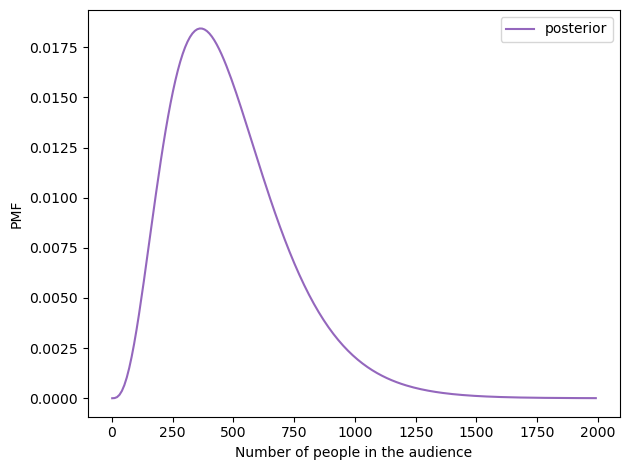

In [47]:
# Prior
hypos = np.arange(1, 2000, 10)
prior = Pmf(1, hypos)
prior.normalize() # Ensure that it represents a valid probability distribution.

# Compute the probability of the data for each hypothetical audience size
from scipy.stats import binom

likelihood1 = binom.pmf(2, hypos, 1/365)
likelihood2 = binom.pmf(1, hypos, 1/365)
likelihood3 = binom.pmf(0, hypos, 1/365)

# Update
posterior = prior * likelihood1 * likelihood2 * likelihood3
posterior.normalize()

# Plot
posterior.plot(color='C4', label='posterior')
decorate(xlabel='Number of people in the audience',
         ylabel='PMF')

# If we have to guess the audience size, we might use the posterior mean
# If you were to take repeated samples from this posterior distribution, their average would be around 486.
print("Expected value of the audience size under the posterior distribution: ", posterior.mean())

# The most likely audience size given the observed data is 361.
print("Most probable value for people in the hall: ", posterior.max_prob())

# Compute the probability of exceeding the capacity of the room.
print("Probability of exceeding the capacity of the hall: ", posterior.prob_gt(1200)) # Right tail

We would opt to use rather the posterior mean because it minimizes the MSE, while MAP minimizes Absolute Error (useful in cases where you need a strict "best guess") and MAP may be misleading with skewed distributions. If you report the mean, you're considering the full uncertainty in the estimate, giving a more balanced guess.

> **Exercise** _If I chose a random adult in the U.S., what is the probability that they have a sibling?  To be precise, what is the probability that their mother has had at least one other child._
>
> _[This article from the Pew Research Center](https://www.pewsocialtrends.org/2015/05/07/family-size-among-mothers/) provides some relevant data. From it, I extracted the following distribution of family size for mothers in the U.S. who were 40-44 years old in 2014:_

1    0.094828
2    0.353448
3    0.310345
4    0.241379
dtype: float64
Probability of having siblings:  0.9051724137931034
Probability of having siblings:  0.9051724137931034


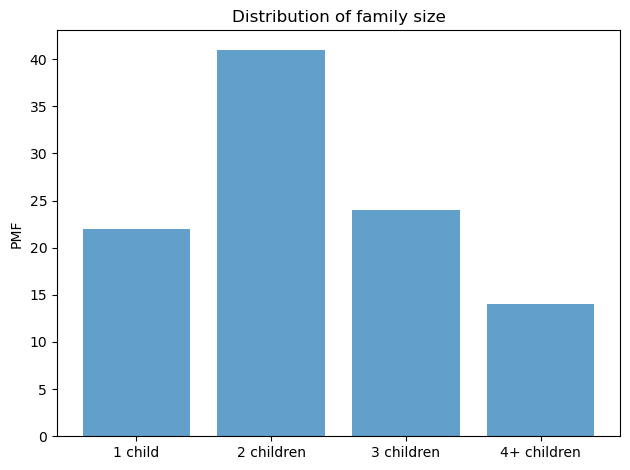

In [ ]:
import matplotlib.pyplot as plt

qs = [1, 2, 3, 4]
ps = [22, 41, 24, 14]
prior = Pmf(ps, qs) # No need to normalize because the given ps values already sum to 100%.
prior.bar(alpha=0.7)

plt.xticks(qs, ['1 child', '2 children', '3 children', '4+ children'])
decorate(ylabel='PMF',
         title='Distribution of family size')

# When you choose a person a random, you are more likely to get someone
# from a bigger family; in fact, the chance of choosing someone from
# any given family is proportional to the number of children
# For simplicity, let’s assume that all families in the 4+ category have exactly 4 children.

likelihood = qs
posterior = prior * likelihood # Unnormalized probs
# After applying the likelihood, the posterior must be normalized to sum to 1.
posterior.normalize() # Proper prob distribution
print(posterior)

# The probability that they have a sibling is the probability
# that they do not come from a family of 1 
print("Probability of having siblings: ", 1 - posterior[1])
print("Probability of having siblings: ", posterior.prob_gt(1)) # It's the same as the previous line

> **Exercise** _Suppose that in the criminal justice system, all prison sentences are either 1, 2, or 3 years, with an equal number of each. One day, you visit a prison and choose a prisoner at random. What is the probability that they are serving a 3-year sentence? What is the average remaining sentence of the prisoners you observe?_


In [60]:
years = [1, 2, 3] # (years = np.arange(1, 4))
prior = Pmf(1, years) # prior = Pmf(1/3, hypos)
prior.normalize()
print(prior)

likelihood = years
posterior = prior * likelihood
posterior.normalize()
print(posterior)

# The mean of the posterior is the average sentence.
# We can divide by 2 to get the average remaining sentence.
# Since we assume a prisoner is equally likely to be at any point 
# in their sentence, the expected remaining time is simply:
print("Remaining sentence time: ", posterior.mean() / 2 , "years")


1    0.333333
2    0.333333
3    0.333333
dtype: float64
1    0.166667
2    0.333333
3    0.500000
dtype: float64
Remaining sentence time:  1.1666666666666665 years


> **Exercise:** _The Doomsday argument is a probabilistic argument that claims to predict the number of future members of the human species given an estimate of the total number of humans born so far._
>
> _Suppose there are only two kinds of intelligent civilizations that can happen in the universe.  The "short-lived" kind go exinct after only 200 billion individuals are born.  The "long-lived" kind survive until 2,000 billion individuals are born.
> And suppose that the two kinds of civilization are equally likely._
> _Which kind of civilization do you think we live in?_
>
> _The Doomsday argument says we can use the total number of humans born so far as data.
> According to the Population Reference Bureau, the total number of people who have ever lived is about 108 billion._
>
> _Since you were born quite recently, let's assume that you are, in fact, human being number 108 billion. If $N$ is the total number who will ever live and we consider you to be a randomly-chosen person, it is equally likely that you could have been person 1, or $N$, or any number in between._
>
> _So what is the probability that you would be number 108 billion?_
>
> _Given this data and dubious prior, what is the probability that our civilization will be short-lived?_

In [66]:
hypos = [200, 2000]
prior = Pmf(1, hypos)

likelihood = 1/prior.qs
print(likelihood)
posterior = prior * likelihood
posterior.normalize()
posterior

200     0.5
2000    0.5
dtype: float64
[0.005  0.0005]


,probs
200,0.909091
2000,0.090909


Normalize after updating with the likelihood
- Before observing data: If all hypotheses have equal priors, normalization isn’t necessary.
- After multiplying by the likelihood: The posterior is proportional to prior * likelihood, but it won’t necessarily sum to 1, so you need to normalize at this step.

Avoid normalizing before likelihood multiplication if all priors are equal:
- As you saw, normalizing before applying the likelihood makes no difference if all priors are the same.
- But if the priors were different, normalizing first could affect results, depending on the computation.

According to this analysis, the probability is about 91% that our civilization will be short-lived, but this conclusion is based on a dubious prior; And with so little data, the posterior depends strongly on the prior. 